<a href="https://colab.research.google.com/github/lorenzocal/Ego4D_NLQ/blob/main/Ego4D_NLQ_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ego4D Moments Benchmark (NLQ) Quickstart

Please set your resources to GPU (Runtime -> Change runtime type -> GPU).

This quickstart will show:
1. An overview of the training data
2. How to train the baseline (VSLNet)

To begin: add your **access keys** below, change your Runtime Type to **GPU**, and run cells **one by one** as you read through. This helps avoid timeouts since Colab gives more GPU cycles to interactive notebooks.

## Resources
- [Baseline Repo](https://github.com/EGO4D/episodic-memory/tree/main/NLQ/VSLNet)
- [Docs](https://ego4d-data.org/docs/benchmarks/episodic-memory/)
- [EvalAI Challenge](https://eval.ai/web/challenges/challenge-page/1629/overview)

## Download Data and Setup Environment

### **Fill In Your Access Info Here**
If you don't have access and secret keys, first sign the Ego4D License at [ego4ddataset.com](https://ego4ddataset.com)

In [ ]:
import os
os.environ['AWS_ACCESS_KEY_ID'] = " < insert access key here >"
os.environ['AWS_SECRET_ACCESS_KEY'] = "< insert secret key here >"

### **Set up CLIs and Download Annotations + Repo**

In [ ]:
# Download the AWS and Ego4D CLIs, then download the annotations locally
%%bash

# Set up the AWS CLI
curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
unzip -o awscliv2.zip >/dev/null
sudo ./aws/install >/dev/null 2>&1
aws configure set aws_access_key_id "$AWS_ACCESS_KEY_ID" && aws configure set aws_secret_access_key "$AWS_SECRET_ACCESS_KEY"
rm "awscliv2.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45.1M  100 45.1M    0     0   132M      0 --:--:-- --:--:-- --:--:--  132M


### Install the ego4d CLI and Download Data

In [ ]:
# Set up the Ego4D CLI
!pip install ego4d

In [ ]:
# Download the Ego4D Annotations to ego4d_data/
!ego4d --output_directory="/content/ego4d_data/" --datasets annotations omnivore_video_swinl_fp16 --benchmarks nlq -y

### Check Downloaded Files

In [ ]:
# Ensure we have downloaded the files correctly
!ls /content/ego4d_data/v1/annotations | grep nlq

In [ ]:
!ls /content/ego4d_data/v1/omnivore_video_swinl_fp16 | wc -l

1260


### Clone the Episodic Memory Baseline Repository

In [ ]:
%%bash
git clone https://github.com/EGO4D/episodic-memory
cd episodic-memory
git pull
git checkout nlq_fixes_and_fp16_support

# Stats for Data

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
ann_data = json.load(open("/content/ego4d_data/v1/annotations/nlq_train.json"))

In [ ]:
# please see https://ego4d-data.org/docs/data/annotations-schemas/

anns = []
for vid in ann_data["videos"]:
    for clip in vid["clips"]:
        for ann in clip["annotations"]:
            for query in ann["language_queries"]:
                anns.append({
                    "query_start_time_sec": clip["video_start_sec"],
                    "query_end_time_sec": clip["video_end_sec"],
                    "query_response_start_time_sec": query["video_start_sec"],
                    "query_response_end_time_sec": query["video_end_sec"],
                    "query_template": query.get("template", None),
                    "query": query.get("query", None),
                })

In [ ]:
num_queries = len(anns)
relative_query_sizes = np.array([
    (a["query_response_end_time_sec"] - a["query_response_start_time_sec"]) / (a["query_end_time_sec"] - a["query_start_time_sec"])
    for a in anns
])
query_sizes = np.array([
    (a["query_response_end_time_sec"] - a["query_response_start_time_sec"])
    for a in anns
])
clip_sizes = np.array([
    (a["query_end_time_sec"] - a["query_start_time_sec"])
    for a in anns
])

## Query / Response Durations

Here we can see that there are some queries with 0s. When training it is reccomended to remove them from the set. For VSLNet you can provide `--remove_empty_queries_from train` to `main.py` (e.g. if you are modifying this codebase).

In [ ]:
query_sizes.max(), query_sizes.min(), query_sizes.std()

(480.0, 0.0, 22.82781402544118)

In [ ]:
# less than or equal to 4 frames => 9% of training data
(query_sizes <= 4/30).sum() / len(relative_query_sizes)

0.09012039660056657

## Distribution of Queries (relative)

Here is a histogram plot of the relative query size to the clip size.

In [ ]:
plt.rcParams["figure.figsize"] = (16, 9)

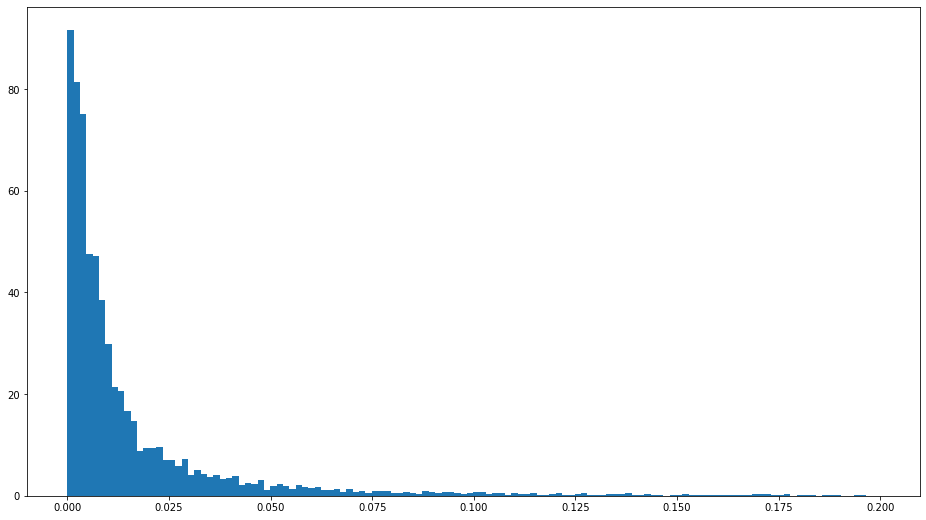

In [ ]:
plt.hist(relative_query_sizes[relative_query_sizes < 0.2], density=True, bins=128)
plt.show()

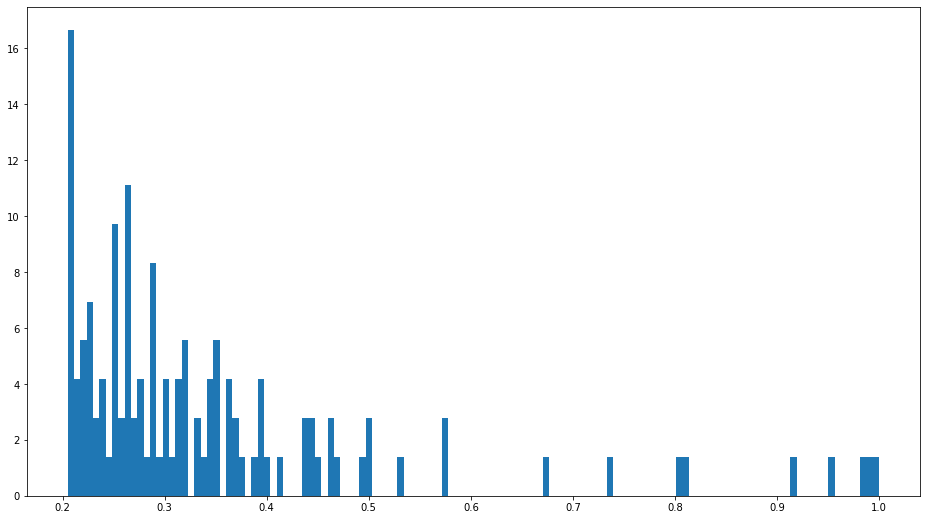

In [ ]:
plt.hist(relative_query_sizes[relative_query_sizes > 0.2], density=True, bins=128)
plt.show()

## Clip Sizes

Clips are 522s on average, with most clips being 480s.

In [ ]:
clip_sizes.mean(), clip_sizes.max(), clip_sizes.min(), clip_sizes.std(), np.median(clip_sizes)

(522.6759852928087,
 1200.0666422526042,
 207.16666666666674,
 197.6377591205408,
 480.0)

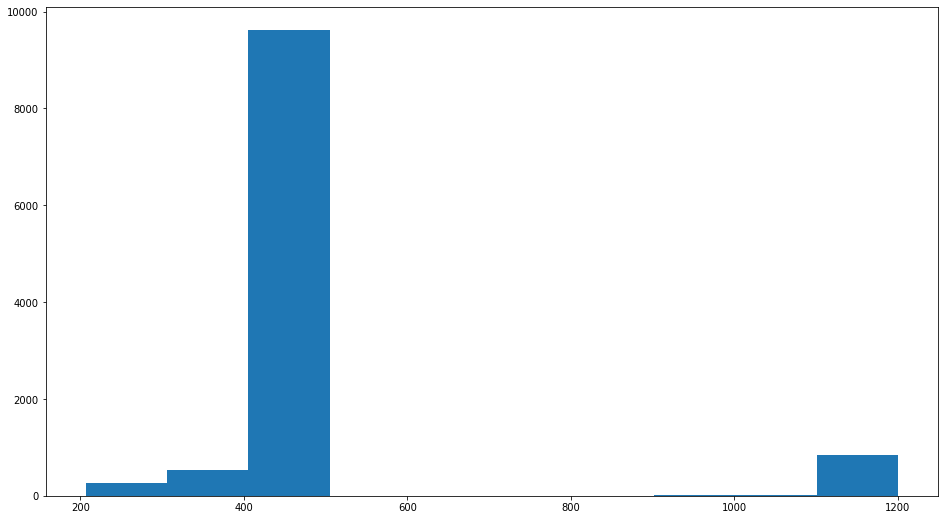

In [ ]:
plt.hist(clip_sizes)
plt.show()

# Prepare Dataset

The NLQ baseline repository for VSLNet requires you to prepare the data for training and evaluation purposes. From the [README.md](https://github.com/EGO4D/episodic-memory/blob/main/NLQ/VSLNet/README.md#preparation) we need to run the `prepare_ego4d_dataset.py` script.

### Setup Environment Variables for NLQ

First let's setup some environment variables and setup the paths as NLQ's scripts will expect.

In [ ]:
with open("vars.sh", "w") as out_f:
  out_f.write("""
export NAME=omnivore_video_fp16
export TASK_NAME=nlq_official_v1_$NAME
export BASE_DIR=data/dataset/nlq_official_v1_$NAME
export FEATURE_BASE_DIR=data/features/nlq_official_v1_$NAME/
export FEATURE_DIR=$FEATURE_BASE_DIR/video_features
export MODEL_BASE_DIR=/content/nlq_official_v1/checkpoints/

cd episodic-memory/NLQ/VSLNet
"""
  )

In [ ]:
%%bash

source vars.sh

echo $FEATURE_BASE_DIR
mkdir -p $FEATURE_BASE_DIR
ln -s /content/ego4d_data/v1/omnivore_video_swinl_fp16 $FEATURE_DIR

data/features/nlq_official_v1_omnivore_video_fp16/


In [ ]:
%%bash
%%capture

source vars.sh
pip install nltk submitit torch torchaudio torchvision tqdm transformers tensorboard Pillow terminaltables

# Train and Evaluation

## Run the Prepare Script

This script will take a while to run and may not output progress until it is done. Please be patient.

In [ ]:
%%bash

source vars.sh

python utils/prepare_ego4d_dataset.py \
    --input_train_split /content/ego4d_data/v1/annotations/nlq_train.json \
    --input_val_split /content/ego4d_data/v1/annotations/nlq_val.json \
    --input_test_split /content/ego4d_data/v1/annotations/nlq_test_unannotated.json \
    --video_feature_read_path $FEATURE_DIR \
    --clip_feature_save_path $FEATURE_BASE_DIR/official \
    --output_save_path $BASE_DIR

Reading [train]: /content/ego4d_data/v1/annotations/nlq_train.json
# train: 11291
Writing [train]: data/dataset/nlq_official_v1_omnivore_video_fp16/train.json
Reading [val]: /content/ego4d_data/v1/annotations/nlq_val.json
# val: 3874
Writing [val]: data/dataset/nlq_official_v1_omnivore_video_fp16/val.json
Reading [test]: /content/ego4d_data/v1/annotations/nlq_test_unannotated.json
# test: 4004
Writing [test]: data/dataset/nlq_official_v1_omnivore_video_fp16/test.json


Extracting features: 100%|██████████| 1659/1659 [02:08<00:00, 12.90it/s]


## Train a Model

Please note:
1. These are *not* the parameters for the original baseline model in the Ego4D whitepaper.
2. Omnivore video features are used (slowfast was originally used), and their FP16 variant. This is due to free colab constraints (100GB disk space).

Omnivore video features do out-perform slowfast features.

In [ ]:
%load_ext tensorboard

You may have to re-run this cell after you run the training script. You can try to reload data.

In [ ]:
!mkdir -p /content/episodic-memory/NLQ/VSLNet/runs/
%tensorboard --logdir /content/episodic-memory/NLQ/VSLNet/runs/

Unfortunately due to colab and the time taken in the below script (it first saves additional metadata to disk) - the cell below takes a while to get started. Please be patient when running it may take at least 30 minutes. You may get timed out from colab.

You can tell if the training is started by inspecting the filesystem on the left hand side. The directory: `episodic-memory/NLQ/VSLNet/runs` will populate with a subdirectory for the tensorboard logdir.

Please note, these are *not* the hyper parameters used for the baseline. The following uses an aggressive learning rate and a low number of epochs, to converge faster so you don't have to wait as long for this cell to finish. :)

In [ ]:
%%bash

source vars.sh

# machine parameters
export DATALOADER_WORKERS=1
export NUM_WORKERS=2
export VAL_JSON_PATH="/content/ego4d_data/v1/annotations/nlq_val.json"

# hyper parameters
export BATCH_SIZE=32
export DIM=128
export NUM_EPOCH=10
export MAX_POS_LEN=128
export INIT_LR=0.0025

export TB_LOG_NAME="${NAME}_bs${BATCH_SIZE}_dim${DIM}_epoch${NUM_EPOCH}_ilr${INIT_LR}"

python main.py \
    --task $TASK_NAME \
    --predictor bert \
    --dim $DIM \
    --mode train \
    --video_feature_dim 1536 \
    --max_pos_len $MAX_POS_LEN \
    --init_lr $INIT_LR \
    --epochs $NUM_EPOCH \
    --batch_size $BATCH_SIZE \
    --fv official \
    --num_workers $NUM_WORKERS \
    --data_loader_workers $DATALOADER_WORKERS \
    --model_dir $MODEL_BASE_DIR/$NAME \
    --eval_gt_json $VAL_JSON_PATH \
    --log_to_tensorboard $TB_LOG_NAME \
    --tb_log_freq 5 \
    --remove_empty_queries_from train